In [1]:
# %load_ext autoreload
# %autoreload 2
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import tensorflow as tf
# import tensorflow.keras as keras
# from tensorflow.keras import backend as K
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import ModelCheckpoint
# import scipy.io

# import models.model_2d as mod
# import forward_model as fm
# import utils as ut
# import cv2
# import io
# import json
# from os import path
# import glob
# import imageio
# from scipy.ndimage import gaussian_filter
# import matplotlib as mpl
# mpl.rc('image', cmap='inferno')

# import sys

In [2]:
%load_ext autoreload
%autoreload 2

import os, glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib as mpl
mpl.rc('image', cmap='inferno')

import models.model_2d as mod
import forward_model_tf as fm
import utils as ut

# Gradually adding stuff to find the culprit of memory issues
import sys
import io
import json
from os import path
import imageio
from scipy.ndimage import gaussian_filter
import cv2

In [3]:
!gpustat

/usr/bin/sh: 1: gpustat: not found


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="1" 

## Load in saved models

Below is the code written initially. It doesn't seem to work, but it does the same thing as some of the code written in `./training_code.py`. The latter does work. Hence, I have copied (below the commented out cells) the stuff from `training_code.py`.

In [5]:
# registered_psfs_path = '../data/multiWienerPSFStack_40z_aligned.mat'
# psfs = scipy.io.loadmat(registered_psfs_path)
# psfs=psfs['multiWienerPSFStack_40z']
# psf=psfs[:,:,0,0]
# psf=psf/np.max(psf)
# psfs=psfs[:,:,:,0]
# psfs=psfs/np.max(psfs)
# Ks =np.ones((1,1,9))
# K=1

In [6]:
#model1 =mod.UNet(486, 648, 
#                         encoding_cs=[24, 64, 128, 256, 512, 1024],
#                         center_cs=1024,
#                         decoding_cs=[512, 256, 128, 64, 24, 24],
#                         skip_connections=[True, True, True, True, True, False])
# model3 =mod.UNet_multiwiener_resize(486, 648, psfs, Ks, 
#                          encoding_cs=[24, 64, 128, 256, 512, 1024],
#                          center_cs=1024,
#                          decoding_cs=[512, 256, 128, 64, 24, 24],
#                          skip_connections=[True, True, True, True, True, False])
#model2 = mod.UNet_wiener(486, 648, psf, K, 
#                         encoding_cs=[24, 64, 128, 256, 512, 1024],
#                         center_cs=1024,
#                         decoding_cs=[512, 256, 128, 64, 24, 24],
#                         skip_connections=[True, True, True, True, True, False])

Here's the promised code:

In [7]:
# choose network type to train
model_type='multiwiener' # choices are 'multiwiener', 'wiener', 'unet'
filter_init_path = '../data/multiWienerPSFStack_40z_aligned.mat' # initialize with 9 PSFs
filter_key = 'multiWienerPSFStack_40z'  # key to load in

In [8]:
if model_type=='unet':
    model =mod.UNet(486, 648, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False])
elif model_type=='wiener':

    registered_psfs_path = filter_init_path
    psfs = scipy.io.loadmat(registered_psfs_path)
    psfs=psfs[filter_key]
    psfs=psfs[:,:,0,0]
    psfs=psfs/np.max(psfs)
    
    Ks=1

    model = mod.UNet_wiener(486, 648, psfs, Ks, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False])
    
    print(psfs.shape, 1)
    
elif model_type=='multiwiener':
    registered_psfs_path = filter_init_path
    psfs = scipy.io.loadmat(registered_psfs_path)
    psfs=psfs[filter_key]
    
    psfs=psfs[:,:,:,0]
    psfs=psfs/np.max(psfs)
    
    Ks =np.ones((1,1,9))
    
    model3 =mod.UNet_multiwiener_resize(486, 648, psfs, Ks, 
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])
    
    print('initialized filter shape:', psfs.shape, 'initialized K shape:', Ks.shape)

initialized filter shape: (486, 648, 9) initialized K shape: (1, 1, 9)


After adding the promised code, it still fails when trying to create the model in memory (before even building it). The only difference I see between this and `training_code.py` (besides the extra stuff that happens in the latter, which doesn't seem like it should have any effect here) is the import stuff. Just for fun, I'll try commenting out the entirety of the import stuff in this notebook (in the first cell) and adding a copy-paste of the import code from `training_code.py`. If this works, I'll comb for the culprit. Otherwise, I'll comb for the extra thing that makes `training_code.py` tick.

**UPDATE:** This actually worked! Some difference in the imports between this and `training_code.py` was causing the OOMs.

In [9]:
model3.build((None, 486, 648, 1))

model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 486, 648, 1  0           []                               
                                )]                                                                
                                                                                                  
 multi_wiener_deconvolution (Mu  (None, 486, 648, 9)  2834361    ['input_1[0][0]']                
 ltiWienerDeconvolution)                                                                          
                                                                                                  
 conv2d (Conv2D)                (None, 486, 648, 24  1944        ['multi_wiener_deconvolution[0][0
                                )                                ]']                          

                                                                                                  
 activation_7 (Activation)      (None, 60, 81, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 30, 40, 256)  0          ['activation_7[0][0]']           
 oling2D)                                                                                         
                                                                                                  
 conv2d_8 (Conv2D)              (None, 30, 40, 512)  1179648     ['average_pooling2d_3[0][0]']    
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 30, 40, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
          

 conv2d_16 (Conv2D)             (None, 30, 40, 256)  2359296     ['concatenate_1[0][0]']          
                                                                                                  
 batch_normalization_16 (BatchN  (None, 30, 40, 256)  1024       ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 30, 40, 256)  0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 30, 40, 256)  589824      ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_17 (BatchN  (None, 30, 40, 256)  1024       ['conv2d_17[0][0]']              
 ormalizat

 concatenate_4 (Concatenate)    (None, 243, 324, 12  0           ['tf.image.resize_4[0][0]',      
                                8)                                'activation_3[0][0]']           
                                                                                                  
 conv2d_25 (Conv2D)             (None, 243, 324, 24  27648       ['concatenate_4[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 243, 324, 24  96         ['conv2d_25[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_25 (Activation)     (None, 243, 324, 24  0           ['batch_normalization_25[0][0]'] 
          

In [10]:
#model1.load_weights('./saved_models/unet')
#model2.load_weights('./saved_models/unetwiener')
model3.load_weights('./saved_models/multiwiener/model_weights')

Text(0.5, 1.0, 'Learned filter')

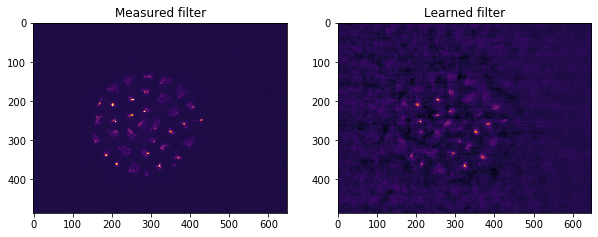

In [11]:
learned_psfs=model3.trainable_variables[0].numpy()
learned_ks=model3.trainable_variables[1].numpy()
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow((psfs[:,:,4]), vmax=0.4) # contrast stretched to show details
ax[0].set_title('Measured filter')
ax[1].imshow((learned_psfs[:,:,4]))
ax[1].set_title('Learned filter')

## Load in real data

In [12]:
restarget=scipy.io.loadmat('../data/real_data/resTargetZ_1.mat')
restarget=restarget['b']


measurement shape: (486, 648)


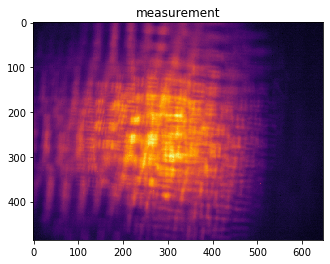

In [13]:
plt.imshow(restarget);
plt.title('measurement');
print('measurement shape:', restarget.shape)

## deconvolve 

In [14]:
#reshaped_target = restarget.reshape((1,486, 648,1))

In [15]:
#recon1=model1.predict(restarget.reshape((1,486, 648,1)))
#recon2=model2.predict(restarget.reshape((1,486, 648,1)))
recon3=model3.predict(restarget.reshape((1,486, 648,1)))
#recon3=model3.predict(reshaped_target)


1/1 [==============================] - 4s 4s/step


In [16]:
#recon_titles = ['Unet', 'WienerNet', 'MultiWienerNet (Ours)']
#recons_np = [recon1[0], recon2[0], recon3[0]]
recon_titles = ['MultiWienerNet (Ours)']
recons_np = [recon3[0]]

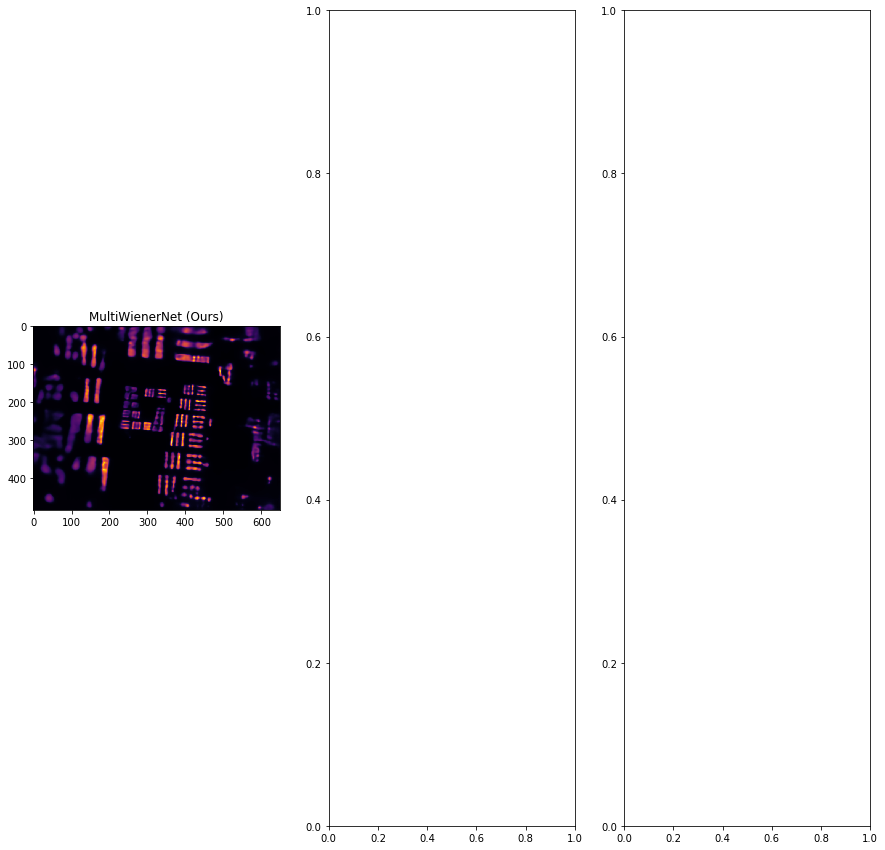

In [17]:
# changed from 3 plots to 1, since we're only looking at the MultiWienerNet
f, ax = plt.subplots(1, 3, figsize=(15,15))
#f, ax = plt.subplots(1, 1, figsize=(15,15))

for i in range(0,len(recons_np)):
    ax[i].imshow((recons_np[i]))
    ax[i].set_title(recon_titles[i])
    


## simulate data and deconvolve it

object shape: (486, 648)


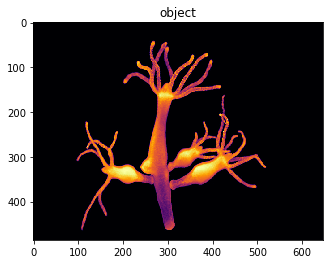

In [18]:
im_in=imageio.imread('../data/hydra3.jpg')
im_in=np.sum(im_in,-1)/3
im=cv2.resize(im_in,(648,486))

plt.imshow(im);
plt.title('object');
print('object shape:', im.shape)

In [1]:
# load forward model weights (these are extracted from the measured PSFs using the SVD model)
# FIXME: specify paths, as per tensorflow/forward_model.load_weights
H,weights,crop_indices=fm.load_weights(h_path='../data/SVD_2_5um_PSF_5um_1_ds4_dsz1_comps_green_SubAvg.mat',
                                      weights_path='../data/SVD_2_5um_PSF_5um_1_ds4_dsz1_weights_green_SubAvg.mat') 
# H and weights are extracted from SVD of the PSFS
# rcL, rcU,ccL, ccU: crop indices used to crop the image to the correct size. 

NameError: name 'fm' is not defined

In [20]:
# simulate data
sim=fm.sim_data(im,H,weights,crop_indices)

measurement shape: (486, 648)


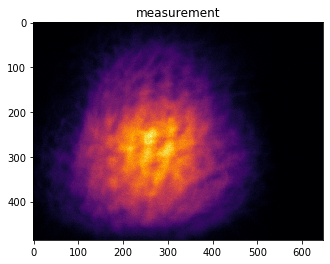

In [21]:
plt.imshow(sim);
plt.title('measurement');
print('measurement shape:', sim.shape)

In [22]:
# recon1=model1.predict(sim.reshape((1,486, 648,1)))
# recon2=model2.predict(sim.reshape((1,486, 648,1)))
recon3=model3.predict(sim.reshape((1,486, 648,1)))


1/1 [==============================] - 0s 24ms/step


In [23]:
# recon_titles = ['Unet', 'WienerNet', 'MultiWienerNet (Ours)']
# recons_np = [recon1[0], recon2[0], recon3[0]]
recon_titles = ['MultiWienerNet (Ours)']
recons_np = [recon3[0]]

MultiWienerNet (Ours) :  PSNR:  20.74


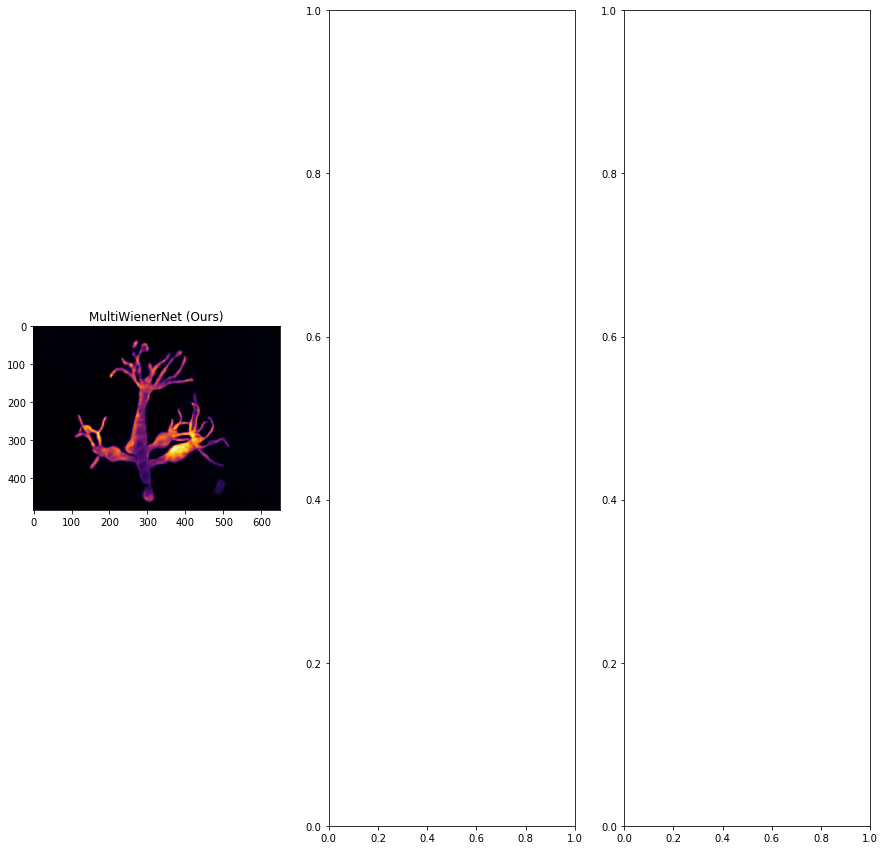

In [24]:
gt_np=im/255.
f, ax = plt.subplots(1, 3, figsize=(15,15))
for i in range(0,len(recons_np)):
    ax[i].imshow((recons_np[i]))
    ax[i].set_title(recon_titles[i])
    
for i in range(0,len(recons_np)):
    print(recon_titles[i], ': ','PSNR: ', np.round(ut.calc_psnr(gt_np, recons_np[i]),2))

### Compare against spatially-varying FISTA

In [25]:
# This fista image is pre-generated with other stuff. I could do that, but not the focus at the moment

# fista_recon=imageio.imread('../data/hydra_fista.png')
# f, ax = plt.subplots(1, 2, figsize=(10,5))
# ax[0].imshow((fista_recon))
# ax[0].set_title('FISTA result')
# ax[1].imshow((recons_np[-1]))
# ax[1].set_title(recon_titles[-1])

## Inspect learned filters

In [26]:
learned_psfs=model3.trainable_variables[0].numpy()
learned_ks=model3.trainable_variables[1].numpy()

Text(0.5, 1.0, 'Learned filter')

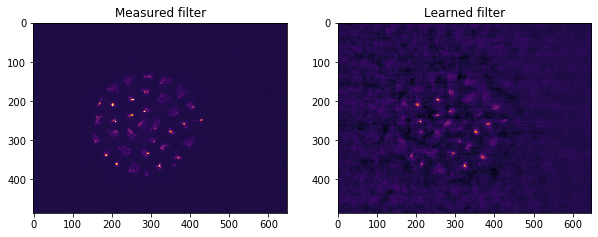

In [27]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow((psfs[:,:,4]), vmax=0.4) # contrast stretched to show details
ax[0].set_title('Measured filter')
ax[1].imshow((learned_psfs[:,:,4]))
ax[1].set_title('Learned filter')

In [28]:
model_wiener_learned=mod.MultiWienerDeconvolution(learned_psfs,learned_ks)
model_wiener_measured=mod.MultiWienerDeconvolution(psfs,Ks)

In [29]:
# ignore the datatype warning
wienerstage_recon_learned=model_wiener_learned(restarget.reshape((1,486, 648,1)).astype('float32'))
wienerstage_recon_measured=model_wiener_measured(restarget.reshape((1,486, 648,1)).astype('float32'))

Text(0.5, 1.0, 'WienerDeconvStage w/ learned filter')

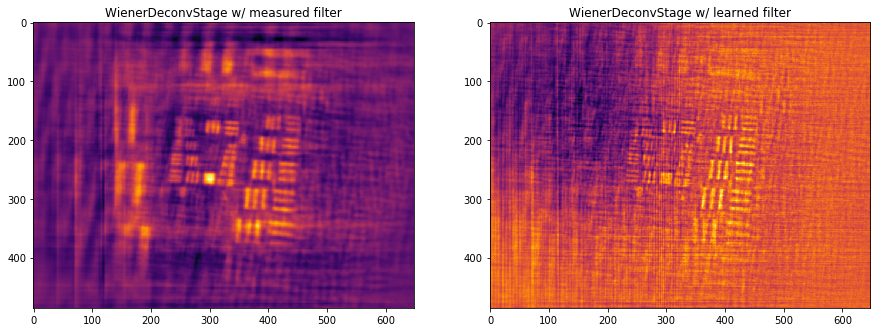

In [30]:
f, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow((wienerstage_recon_measured.numpy()[0,:,:,4])) 
ax[0].set_title('WienerDeconvStage w/ measured filter')
ax[1].imshow((wienerstage_recon_learned.numpy()[0,:,:,4]))
ax[1].set_title('WienerDeconvStage w/ learned filter')


Note how deconvolution with the learned filter yields sharper intermediate results. Zoom in on the middle of the resolution target

In [31]:
# How many trainable variables are there in the model?
len(model3.trainable_variables)

97

In [32]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 486, 648, 1  0           []                               
                                )]                                                                
                                                                                                  
 multi_wiener_deconvolution (Mu  (None, 486, 648, 9)  2834361    ['input_1[0][0]']                
 ltiWienerDeconvolution)                                                                          
                                                                                                  
 conv2d (Conv2D)                (None, 486, 648, 24  1944        ['multi_wiener_deconvolution[0][0
                                )                                ]']                          

                                                                                                  
 activation_7 (Activation)      (None, 60, 81, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 30, 40, 256)  0          ['activation_7[0][0]']           
 oling2D)                                                                                         
                                                                                                  
 conv2d_8 (Conv2D)              (None, 30, 40, 512)  1179648     ['average_pooling2d_3[0][0]']    
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 30, 40, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
          

 conv2d_16 (Conv2D)             (None, 30, 40, 256)  2359296     ['concatenate_1[0][0]']          
                                                                                                  
 batch_normalization_16 (BatchN  (None, 30, 40, 256)  1024       ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 30, 40, 256)  0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 30, 40, 256)  589824      ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_17 (BatchN  (None, 30, 40, 256)  1024       ['conv2d_17[0][0]']              
 ormalizat

 concatenate_4 (Concatenate)    (None, 243, 324, 12  0           ['tf.image.resize_4[0][0]',      
                                8)                                'activation_3[0][0]']           
                                                                                                  
 conv2d_25 (Conv2D)             (None, 243, 324, 24  27648       ['concatenate_4[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 243, 324, 24  96         ['conv2d_25[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_25 (Activation)     (None, 243, 324, 24  0           ['batch_normalization_25[0][0]'] 
          